In [4]:
import sys
sys.path.append('/Users/evatakou/noise_est')
import stim
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pymatching import Matching
import matplotlib

In [5]:

from sims.repetition_code_Steane_SE.four_point_method import *
from sims.repetition_code_Steane_SE.rep_code_Steane_circuit import *
from utilities.utils_for_decoding import *
from utilities.general_utils import *
from sims.repetition_code_Steane_SE.utilities_for_Steane_SE import *
from sims.repetition_code_Steane_SE.construct_dem import *

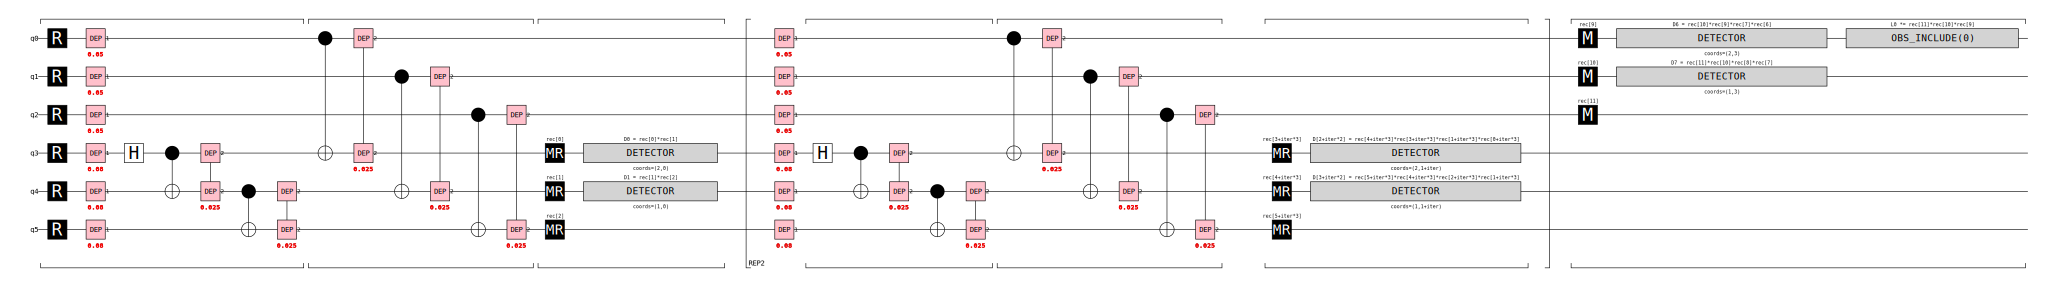

In [6]:
distance              = 3
num_rounds            = 3
p_data                = 0.05
p_anc                 = 0.08
p_depol_after         = 0.025

Reset                 = True
after_CNOT_depol_type = 'DEPOLARIZE2' #X_ERROR
logical_state         = '0'

circuit = repetition_code_circuit_Steane_Extraction(distance, num_rounds, p_data, p_anc, Reset, p_depol_after, after_CNOT_depol_type, logical_state)

circuit.diagram("timeline-svg")

In [7]:
def estimate_edges(num_shots_est,distance,num_rounds,circuit):

    p_depol_after_for_4cnts = [] #Do not make any assumption that we know this value
    defects_matrix          = get_defects_matrix(distance,num_rounds,num_shots_est,circuit)
    vi_mean                 = avg_vi(defects_matrix)
    vivj_mean               = avg_vivj(defects_matrix.data)
    p4_cnts                 = get_4_pnt_events(defects_matrix.data,p_depol_after_for_4cnts)
    
    
    num_ancilla = distance-1


    det_inds_rd_anc = get_det_inds_as_rd_anc_pairs(num_rounds,num_ancilla)
    vijkl           = get_vijkl(p4_cnts,num_rounds,num_ancilla,vi_mean,vivj_mean,det_inds_rd_anc)

    min_bound = 1e-6
    max_bound = 0.8
    method    = "least_squares" 
    all_dicts = solve_system_of_equations(min_bound,max_bound,method,vijkl)    


    bulk_edges,time_edges,bd_edges   = edge_dicts(num_ancilla,num_rounds)
    pij_bulk,pij_time,pij_bd,p4_cnts = fill_initial_prob_values(all_dicts,bulk_edges,time_edges,bd_edges)


    pij_bulk, pij_time, pij_bd, p4_cnts = update_edges_after_4_pnt_estimation(pij_bulk,pij_time,pij_bd,p4_cnts
                                                                            ,num_ancilla,num_rounds,vi_mean,distance)

    
    return pij_bulk,pij_time,pij_bd,p4_cnts


num_shots_est                    = 10**7
pij_bulk,pij_time,pij_bd,p4_cnts = estimate_edges(num_shots_est,distance,num_rounds,circuit)




In [8]:
#Find relative error in edge estimation:

def compare_error_in_edge_estimation(pij_bulk,pij_time,pij_bd,p4_cnts,circuit):

    #get stim's DEM
    DEM = circuit.detector_error_model(flatten_loops=True)

    DEM_dict={}

    for instruction in DEM:

        if instruction.type=="error":

            targets   = instruction.targets_copy()
            error_val = instruction.args_copy()[0]
            
            temp=[]
            for target in targets:

                if target.is_relative_detector_id():
                

                    detector_id = target.val

                    temp.append("D"+str(detector_id))
                
                elif target.is_logical_observable_id():
                    continue

            DEM_dict[tuple(temp)]=error_val
        
        else:
            break
    

    pij_bulk_rel_error = {}
    pij_time_rel_error = {}
    pij_bd_rel_error   = {}
    p4_cnts_rel_error  = {}

    for key in pij_bulk.keys():

        pij_bulk_rel_error[key] = abs(pij_bulk[key]-DEM_dict[key])/DEM_dict[key]

    for key in pij_time.keys():
        pij_time_rel_error[key] = abs(pij_time[key]-DEM_dict[key])/DEM_dict[key]

    for key in pij_bd.keys():

        other_key = (key,)
        pij_bd_rel_error[key] = abs(pij_bd[key]-DEM_dict[other_key])/DEM_dict[other_key]

    for key in p4_cnts.keys():

        p4_cnts_rel_error[key] = abs(p4_cnts[key]-DEM_dict[key])/DEM_dict[key]



    return pij_bulk_rel_error,pij_time_rel_error,pij_bd_rel_error,p4_cnts_rel_error


pij_bulk_rel_error,pij_time_rel_error,pij_bd_rel_error,p4_cnts_rel_error = compare_error_in_edge_estimation(pij_bulk,pij_time,pij_bd,p4_cnts,circuit)



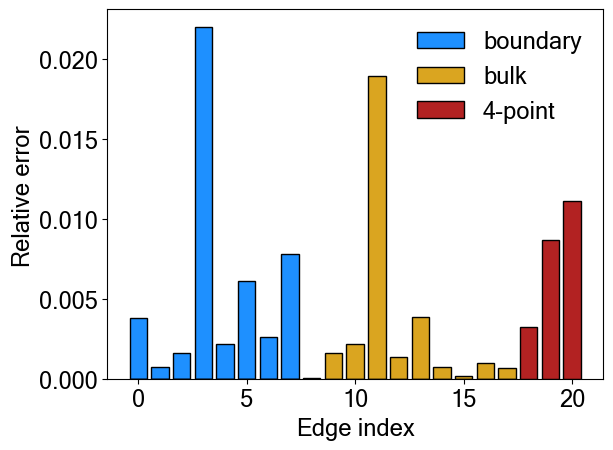

In [10]:
#------- Plot as a single graph with different colored bars ------


fig, ax = plt.subplots()


matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"

plt.bar(x=np.arange(len(pij_bd_rel_error)),height=list(pij_bd_rel_error.values())
        ,facecolor='dodgerblue',
        edgecolor ='black')


plt.bar(x=np.arange(len(pij_bd_rel_error)+len(pij_bulk_rel_error)+len(pij_time_rel_error)),
        height=list([0]*len(pij_bd_rel_error))+list(pij_bulk_rel_error.values())+
        list(pij_time_rel_error.values()),
        facecolor='goldenrod',
        edgecolor ='black')


plt.bar(x=np.arange(len(pij_bd_rel_error)+len(pij_bulk_rel_error)+len(pij_time_rel_error)+len(p4_cnts_rel_error) 
                    ),
        height=
        list([0]*len(pij_bd_rel_error))
        +list([0]*len(pij_bulk_rel_error))
        +list([0]*len(pij_time_rel_error))
        +
        list(p4_cnts_rel_error.values()),
        facecolor='firebrick',
        edgecolor ='black')



plt.legend(["boundary","bulk","4-point"]
           ,frameon=False,
           shadow=True)

plt.ylabel("Relative error")
plt.xlabel("Edge index")
plt.show()

#Uncomment to save the figure
# fig.savefig("relative_edge_error_d_3_r_3_N_est_10_7.pdf",bbox_inches='tight')




